# Imports

In [1]:
import math
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

In [2]:
data = pd.read_csv('score-records.csv')
companies = pd.read_csv('companies.csv')

# Objective
We want to create an app for benchmarking an engineer's coding and communication skills against other engineers that work at similar companies and with the same title (e.g. Junior Engineer)

# Instructions
1. Write a function that takes a candidate_id and returns their percentile for their coding and commmunication score compared to other candidates at the same title and at similar companies.
2. Write a React app that allows a user to enter their candidate id and see their percentiles.
3. Please add automated tests as you see fit.

# Data
- `score-records.csv` contains the coding and communication scores for all of the users in our sample dataset (https://s3.amazonaws.com/simple-fractal-recruiting/score-records.csv)
- `companies.csv` contains the list of firms along with their `fractal_index` (https://s3.amazonaws.com/simple-fractal-recruiting/companies.csv)

# Definitions
- communication_score: a measurement of the candidate's ability to communicate
- coding_score: a measurement of the candidate's technical ability
- title: the role that the candidate performs at their company, e.g. Senior Engineer

# Data Exploration

In [3]:
data.head()

,candidate_id,communication_score,coding_score,title,company_id
0,889,114028,180944,Engineer,2
1,890,62734,64000,Engineer,2
2,891,167656,231216,Engineer,2
3,892,163198,202131,Engineer,2
4,893,109561,137014,Engineer,2


In [4]:
data.tail()

,candidate_id,communication_score,coding_score,title,company_id
54,943,80593,155505,Engineer,5
55,944,95437,122643,Engineer,5
56,945,114747,148033,Engineer,5
57,946,74387,134410,Engineer,5
58,947,85180,133854,Engineer,5


In [5]:
type(data)

pandas.core.frame.DataFrame

In [6]:
data.count()

candidate_id           59
communication_score    59
coding_score           59
title                  59
company_id             59
dtype: int64

## Data Cleaning - Checking for Nulls

In [7]:
pd.isnull(data).any()

candidate_id           False
communication_score    False
coding_score           False
title                  False
company_id             False
dtype: bool

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 5 columns):
candidate_id           59 non-null int64
communication_score    59 non-null int64
coding_score           59 non-null int64
title                  59 non-null object
company_id             59 non-null int64
dtypes: int64(4), object(1)
memory usage: 2.4+ KB


In [9]:
companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
company_id       5 non-null int64
fractal_index    5 non-null float64
dtypes: float64(1), int64(1)
memory usage: 208.0 bytes


## Data Visualization

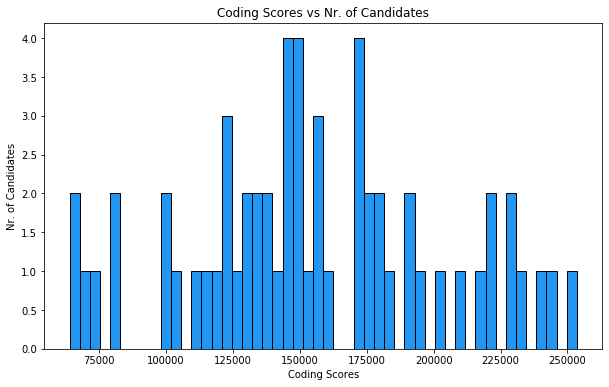

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(data['coding_score'], bins=50, ec='black', color='#2196f3')
plt.title('Coding Scores vs Nr. of Candidates')
plt.xlabel('Coding Scores')
plt.ylabel('Nr. of Candidates')
plt.show()

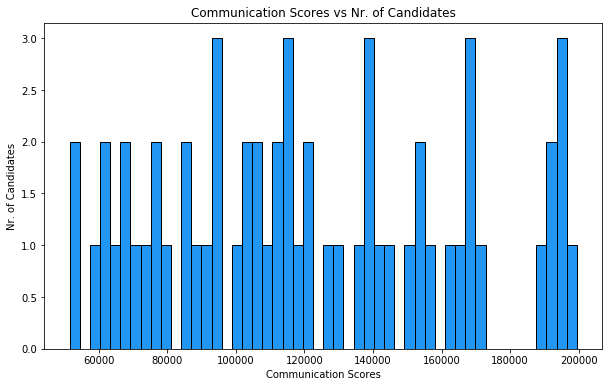

In [11]:
plt.figure(figsize=(10, 6))
plt.hist(data['communication_score'], bins=50, ec='black', color='#2196f3')
plt.title('Communication Scores vs Nr. of Candidates')
plt.xlabel('Communication Scores')
plt.ylabel('Nr. of Candidates')
plt.show()

# Data Exploration - Companies

In [12]:
companies

,company_id,fractal_index
0,1,0.678
1,2,0.782
2,3,0.795
3,4,0.724
4,5,0.523


In [13]:
companies.loc[companies['company_id'] == 2]

,company_id,fractal_index
1,2,0.782


In [14]:
c1 = companies.loc[companies['company_id'] == 2]

In [15]:
c1['fractal_index'].values[0]

0.782

# Python Formulas

## Similarity Method

In [69]:
def are_similar(company_1, company_2):
    c1 = companies.loc[companies['company_id'] == company_1]
    c2 = companies.loc[companies['company_id'] == company_2]
    return math.fabs(c1['fractal_index'].values[0] - c2['fractal_index'].values[0]) < 0.15

In [17]:
are_similar(2, 3)

True

## Candidate Performance

### Percentile rank formula

$ Percental = \frac{count below}{total count} * 100 $

In [102]:
# filter data to peers with sorted scores

# slice data by title
def slice_by_title_and_company(title, company_id):
    title_mask = data['title'] == title
    peers = data[title_mask]
    to_drop = []
    
    for i in range(len(peers)):
        if not are_similar(company_id, peers.values[i][4]):
            to_drop.append(i)

    return peers

# add rank col to data
def rank_col_by_name(data, filtered_set, col_name, rank_col):
    data[col_name] = filtered_set[rank_col].rank(ascending=True)
    return data
    

# get percentiles by id
def candidate_code_percentile(candidate_id):
    candidate_profile = data.loc[data['candidate_id'] == candidate_id]

    company_id = candidate_profile['company_id'].values[0]
    
    
    candidate_title = candidate_profile['title'].values[0]
    peers = slice_by_title_and_company(candidate_title, company_id)
    col = rank_col_by_name(
        data=data, 
        filtered_set=peers, 
        col_name='coding_rank', 
        rank_col='coding_score'
    )

    candidate_rank = candidate_profile['coding_rank'].values[0]
    print(f'coding_rank: ', candidate_rank)
    num_ranked_below = (candidate_rank - 1)
    total_num_ranked = data['coding_rank'].max()
    
    percentile = round((num_ranked_below / total_num_ranked) * 100, 2)
    return percentile

def candidate_communication_percentile(candidate_id):
    candidate_profile = data.loc[data['candidate_id'] == candidate_id]
    
    company_id = candidate_profile['company_id'].values[0]
    
    candidate_title = candidate_profile['title'].values[0]
    peers = slice_by_title_and_company(candidate_title, company_id)
    col = rank_col_by_name(
        data=data, 
        filtered_set=peers, 
        col_name='communication_rank', 
        rank_col='communication_score'
    )
    
    candidate_rank = candidate_profile['communication_rank'].values[0]
    print(f'comm rank: ', candidate_rank)
    num_ranked_below = (candidate_rank - 1)
    total_num_ranked = data['communication_rank'].max()
    
    percentile = round((num_ranked_below / total_num_ranked) * 100, 0)
    return percentile

candidate_1 = 893
print(f'Candidate {candidate_1} is in the {candidate_code_percentile(893)}% coding percentile.')
print(f'Candidate {candidate_1} is in the {candidate_communication_percentile(893)}% communication percentile.')

coding_rank:  19.0
Candidate 893 is in the 40.0% coding percentile.
comm rank:  21.0
Candidate 893 is in the 44.0% communication percentile.


In [104]:
def candidate_performance(candidate_id):
    code_percentile = candidate_code_percentile(candidate_id)
    communication_percentile = candidate_communication_percentile(candidate_id)
    
    print(f'Candidate {candidate_id} is in the {code_percentile}% coding percentile.')
    print(f'Candidate {candidate_id} is in the {communication_percentile}% communication percentile.')
    return({'code_percentile': code_percentile, 'communication_percentile': communication_percentile})
    

# Input Candidate Id:

In [105]:
candidate_performance(930)

coding_rank:  30.0
comm rank:  32.0
Candidate 930 is in the 64.44% coding percentile.
Candidate 930 is in the 69.0% communication percentile.


{'code_percentile': 64.44, 'communication_percentile': 69.0}